#### Audio Classification Data Preprocessing

In [1585]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Flatten, Dense
from keras import Sequential
from keras.callbacks import ModelCheckpoint
from datetime import datetime

LABEL_ENCODER = LabelEncoder()

In [1586]:
audio_file_path = 'dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/3acc7440-4479-11e9-a9a5-5dbec3b8816a.wav'
librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path)

In [1587]:
print(librosa_audio_data)

[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 6.0792456e-05 7.0427333e-05
 0.0000000e+00]


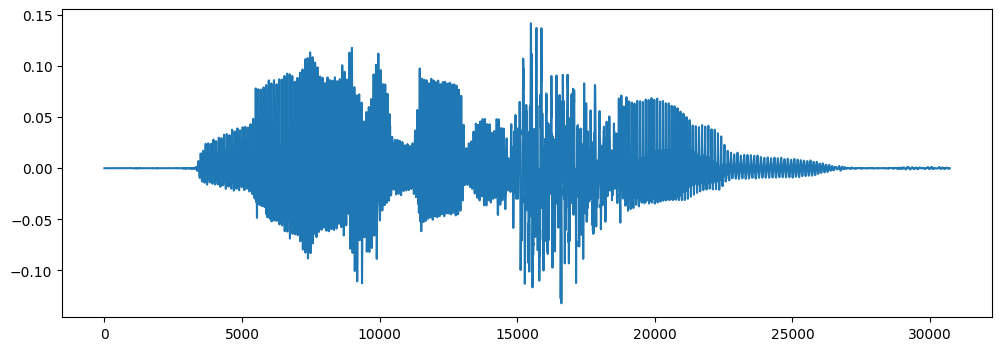

In [1588]:
### Lets plot the librosa audio data
# Original audio with 1 channel
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

#### Observation
Here Librosa converts the signal to mono, meaning the channel will alays be 1

In [1589]:
### Lets read with scipy
wave_sample_rate, wave_audio = wav.read(audio_file_path)  #%% md
#### Audio Classification Data Preprocessing

In [1590]:
### Let's read a sample audio using librosa
audio_file_path = 'dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/3acc7440-4479-11e9-a9a5-5dbec3b8816a.wav'
librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path)

In [1591]:
print(librosa_audio_data)

[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 6.0792456e-05 7.0427333e-05
 0.0000000e+00]


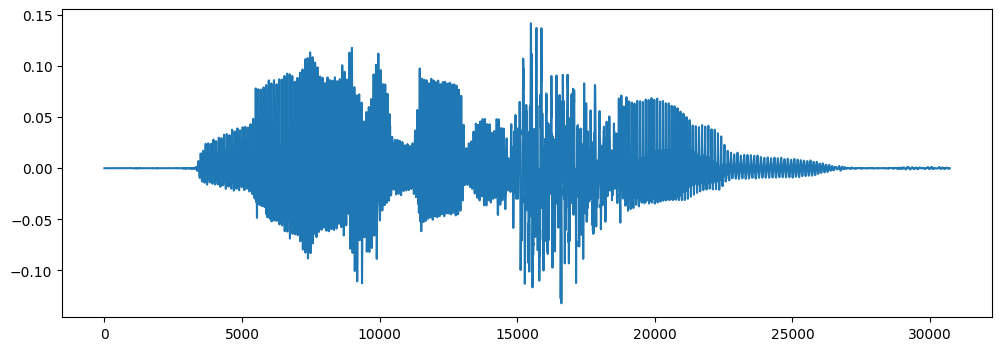

In [1592]:
### Lets plot the librosa audio data
# Original audio with 1 channel
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

#### Observation
Here Librosa converts the signal to mono, meaning the channel will alays be 1

In [1593]:
### Lets read with scipy
wave_sample_rate, wave_audio = wav.read(audio_file_path)

In [1594]:
wave_audio

array([0, 0, 0, ..., 2, 2, 2], dtype=int16)

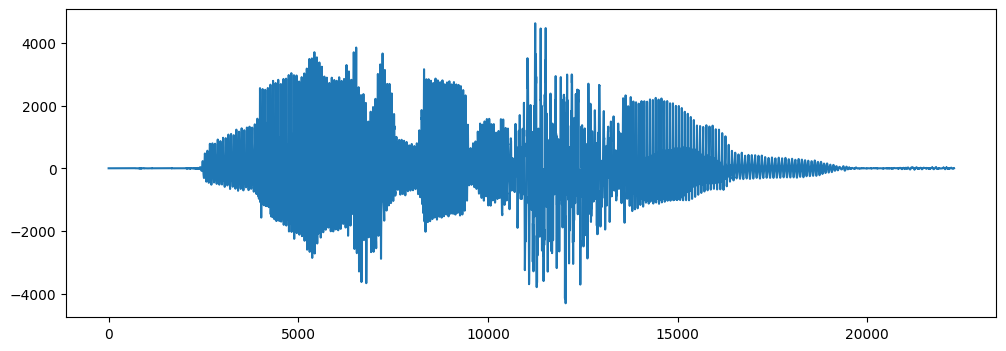

In [1595]:
# Original audio with 2 channels
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)

### Extract Features
Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio
samples.
The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

In [1596]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 61)


In [1597]:
mfccs

array([[-7.4111920e+02, -7.3793085e+02, -7.3372919e+02, ...,
        -6.9023126e+02, -6.9762494e+02, -7.0923523e+02],
       [ 2.4239039e+00,  6.8581419e+00,  1.2462606e+01, ...,
         6.7299309e+01,  5.9293739e+01,  4.5494789e+01],
       [ 2.4126921e+00,  6.6367674e+00,  1.1383302e+01, ...,
         5.1713745e+01,  4.8966675e+01,  3.9999344e+01],
       ...,
       [ 6.8057328e-05, -5.7721716e-01, -1.0462627e+00, ...,
        -9.3867071e-02,  1.1653264e+00, -9.1525936e-01],
       [-3.5942774e-02, -5.5208266e-01, -1.3430347e+00, ...,
        -3.0128503e-01,  2.2019703e+00, -3.5509074e-01],
       [-6.7361191e-02, -5.4289007e-01, -1.7864795e+00, ...,
        -6.5210921e-01,  1.7860074e+00, -3.3926344e-01]], dtype=float32)

In [1598]:
#### Extracting MFCC's For every audio file
audio_dataset_path = 'dsl_data/audio'
metadata = pd.read_csv('dsl_data/development.csv')

metadata.drop('Id', axis=1, inplace=True)
#TODO REMOVE ME
metadata = metadata.sample(frac=0.01, random_state=42)

metadata.head()

,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
8353,dsl_data/audio/speakers/ZebMRl5Z7dhrPKRD/d4441...,ZebMRl5Z7dhrPKRD,decrease,volume,native,English (United States),English (United States),male,41-65
9843,dsl_data/audio/speakers/Pz327QrLaGuxW8Do/78636...,Pz327QrLaGuxW8Do,decrease,heat,native,English (United States),English (United States),female,22-40
1851,dsl_data/audio/speakers/BvyakyrDmQfWEABb/447cf...,BvyakyrDmQfWEABb,decrease,volume,native,English (United States),English (United States),male,22-40
7209,dsl_data/audio/speakers/xPZw23VxroC3N34k/9d35a...,xPZw23VxroC3N34k,change language,none,native,English (United States),English (United States),female,22-40
3742,dsl_data/audio/speakers/kNnmb7MdArswxLYw/42458...,kNnmb7MdArswxLYw,increase,volume,native,English (United States),English (United States),female,41-65


In [1599]:
metadata.drop(metadata[metadata['First Language spoken'] != 'English (United States)'].index, inplace=True)
metadata.drop(metadata[metadata['Current language used for work/school'] != 'English (United States)'].index,
              inplace=True)

In [1600]:
def mfccs_extractor(file):
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast')
    audio, _ = librosa.effects.trim(audio)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=140)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

In [1601]:
def spectogram_extractor(file):
    y, sr = librosa.load(file)
    melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    melspectrogram_scaled_features = np.mean(melspectrogram.T, axis=0)
    return melspectrogram_scaled_features

In [1602]:
def create_sentence(row):
    return row["action"] + row["object"]

In [1603]:
mapping = {metadata.columns[4]: 'Fluency', }
metadata = metadata.rename(columns=mapping)
metadata.head()

,path,speakerId,action,object,Fluency,First Language spoken,Current language used for work/school,gender,ageRange
8353,dsl_data/audio/speakers/ZebMRl5Z7dhrPKRD/d4441...,ZebMRl5Z7dhrPKRD,decrease,volume,native,English (United States),English (United States),male,41-65
9843,dsl_data/audio/speakers/Pz327QrLaGuxW8Do/78636...,Pz327QrLaGuxW8Do,decrease,heat,native,English (United States),English (United States),female,22-40
1851,dsl_data/audio/speakers/BvyakyrDmQfWEABb/447cf...,BvyakyrDmQfWEABb,decrease,volume,native,English (United States),English (United States),male,22-40
7209,dsl_data/audio/speakers/xPZw23VxroC3N34k/9d35a...,xPZw23VxroC3N34k,change language,none,native,English (United States),English (United States),female,22-40
3742,dsl_data/audio/speakers/kNnmb7MdArswxLYw/42458...,kNnmb7MdArswxLYw,increase,volume,native,English (United States),English (United States),female,41-65


In [1604]:
tqdm.pandas(ncols=50)
metadata["mfccs_scaled_features"] = metadata['path'].progress_apply(lambda path: mfccs_extractor(path))

100%|█████████████| 95/95 [00:02<00:00, 42.84it/s]


In [1605]:
metadata["spectogram_features"] = metadata['path'].progress_apply(lambda path: spectogram_extractor(path))
metadata.drop('path', axis=1, inplace=True)

100%|█████████████| 95/95 [00:06<00:00, 13.64it/s]


In [1606]:
metadata["sentence"] = metadata.progress_apply(create_sentence, axis=1)
metadata.drop('action', axis=1, inplace=True)
metadata.drop('object', axis=1, inplace=True)

100%|██████████| 95/95 [00:00<00:00, 47082.46it/s]


In [1607]:
metadata['speakerId'] = LABEL_ENCODER.fit_transform(metadata['speakerId'])
metadata['Fluency'] = LABEL_ENCODER.fit_transform(metadata['Fluency'])
metadata['First Language spoken'] = LABEL_ENCODER.fit_transform(metadata['First Language spoken'])
metadata['Current language used for work/school'] = LABEL_ENCODER.fit_transform(metadata['Current language used for work/school'])
metadata['gender'] = LABEL_ENCODER.fit_transform(metadata['gender'])
metadata['ageRange'] = LABEL_ENCODER.fit_transform(metadata['ageRange'])
metadata = metadata.reindex(sorted(metadata.columns), axis=1)
metadata.head()

,Current language used for work/school,First Language spoken,Fluency,ageRange,gender,mfccs_scaled_features,sentence,speakerId,spectogram_features
8353,0,0,2,1,1,"[-353.67584, 124.34815, -17.01657, 21.43007, -...",decreasevolume,31,"[0.033234935, 0.037382357, 0.05349339, 1.82341..."
9843,0,0,2,0,0,"[-253.13905, 149.57301, -54.908997, 40.645325,...",decreaseheat,23,"[0.0019949665, 0.009163819, 0.3090853, 1.06552..."
1851,0,0,2,0,1,"[-431.81976, 64.565544, 9.129413, 31.864378, -...",decreasevolume,12,"[0.0044266614, 0.0025381034, 0.005213033, 0.16..."
7209,0,0,2,0,0,"[-280.04068, 42.362423, -45.814224, 62.497322,...",change languagenone,50,"[0.00092060404, 0.00026416613, 0.0004829344, 0..."
3742,0,0,2,1,0,"[-292.44995, 119.65166, -50.21545, -2.0956755,...",increasevolume,39,"[0.0002643755, 0.00032125672, 0.00036654077, 0..."


In [1608]:
### Split the dataset into independent and dependent dataset
X = np.array(metadata['mfccs_scaled_features'].tolist())
Z = np.array(metadata['spectogram_features'].tolist())
metadata.drop('mfccs_scaled_features', axis=1, inplace=True)
metadata.drop('spectogram_features', axis=1, inplace=True)

sentences_list = np.array(metadata['sentence'].tolist())
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
SENTENCE_ENCODER = LabelEncoder()
y = SENTENCE_ENCODER.fit_transform(sentences_list)

# metadata.drop('sentence_encoded', axis=1, inplace=True)
metadata.drop('sentence', axis=1, inplace=True)
metadata.head()

,Current language used for work/school,First Language spoken,Fluency,ageRange,gender,speakerId
8353,0,0,2,1,1,31
9843,0,0,2,0,0,23
1851,0,0,2,0,1,12
7209,0,0,2,0,0,50
3742,0,0,2,1,0,39


In [1609]:
y

array([4, 3, 4, 1, 6, 6, 0, 5, 1, 4, 3, 5, 5, 6, 3, 0, 2, 3, 4, 6, 4, 1,
       4, 4, 5, 2, 4, 4, 6, 5, 1, 4, 6, 4, 1, 0, 5, 6, 0, 0, 4, 6, 4, 6,
       3, 2, 1, 6, 1, 4, 3, 5, 6, 5, 3, 3, 5, 6, 2, 4, 4, 1, 4, 3, 1, 4,
       3, 6, 0, 0, 4, 4, 1, 6, 6, 1, 5, 4, 0, 2, 4, 4, 4, 1, 4, 6, 1, 6,
       3, 4, 0, 6, 6, 6, 3], dtype=int64)

In [1610]:
metadata_converted = metadata.to_numpy()
metadata_converted.shape

(95, 6)

In [1611]:
X.shape

(95, 128)

In [1612]:
X = np.append(X, Z, axis=1)

In [1613]:
X.shape

(95, 256)

In [1614]:
X = np.append(X, metadata_converted, axis=1)

In [1615]:
X.shape

(95, 262)

In [1616]:
X

array([[-353.67584229,  124.34815216,  -17.01656914, ...,    1.        ,
           1.        ,   31.        ],
       [-253.13905334,  149.57301331,  -54.90899658, ...,    0.        ,
           0.        ,   23.        ],
       [-431.81976318,   64.56554413,    9.12941265, ...,    0.        ,
           1.        ,   12.        ],
       ...,
       [-417.76455688,   60.67008209,    9.83849716, ...,    0.        ,
           1.        ,   29.        ],
       [-392.03726196,  120.31343842,   -9.95514584, ...,    0.        ,
           1.        ,   22.        ],
       [-457.83822632,   26.20721817,  -12.03195   , ...,    1.        ,
           0.        ,    7.        ]])

In [1617]:
y.shape

(95,)

In [1618]:
### Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [1619]:
X_train.shape

(76, 262)

In [1620]:
X_test.shape

(19, 262)

In [1621]:
y_train.shape

(76,)

In [1622]:
y_test.shape

(19,)

### Model Creation

### Testing Some Test Audio Data

Steps
- Preprocess the new audio data
- predict the classes
- Invere transform your Predicted Label

In [1626]:
evaluation_df = pd.read_csv('evaluation.csv')
evaluation_df.drop('Id', axis=1, inplace=True)

#TODO REMOVE ME
evaluation_df = evaluation_df.sample(frac=0.01, random_state=42)

mapping = {evaluation_df.columns[2]: 'Fluency', }
evaluation_df = evaluation_df.rename(columns=mapping)

evaluation_df.head()

,path,speakerId,Fluency,First Language spoken,Current language used for work/school,gender,ageRange
497,dsl_data/audio/speakers/V4ejqNL4xbUKkYrV/4257a...,V4ejqNL4xbUKkYrV,native,English (United States),English (United States),male,22-40
1261,dsl_data/audio/speakers/k5bqyxx2lzIbrlg9/25e04...,k5bqyxx2lzIbrlg9,native,English (United States),English (United States),male,22-40
411,dsl_data/audio/speakers/V4ejqNL4xbUKkYrV/f0ff7...,V4ejqNL4xbUKkYrV,native,English (United States),English (United States),male,22-40
1046,dsl_data/audio/speakers/Q4vMvpXkXBsqryvZ/ff6df...,Q4vMvpXkXBsqryvZ,native,English (United States),English (United States),female,41-65
1033,dsl_data/audio/speakers/Q4vMvpXkXBsqryvZ/529b4...,Q4vMvpXkXBsqryvZ,native,English (United States),English (United States),female,41-65


In [1627]:
evaluation_df["mfccs_scaled_features"] = evaluation_df['path'].progress_apply(lambda path: mfccs_extractor(path))
evaluation_df["spectogram_features"] = evaluation_df['path'].progress_apply(lambda path: spectogram_extractor(path))
evaluation_df.drop('path', axis=1, inplace=True)

evaluation_df['speakerId'] = LABEL_ENCODER.fit_transform(evaluation_df['speakerId'])
evaluation_df['Fluency'] = LABEL_ENCODER.fit_transform(evaluation_df['Fluency'])
evaluation_df['First Language spoken'] = LABEL_ENCODER.fit_transform(evaluation_df['First Language spoken'])
evaluation_df['Current language used for work/school'] = LABEL_ENCODER.fit_transform(evaluation_df['Current language used for work/school'])
evaluation_df['gender'] = LABEL_ENCODER.fit_transform(evaluation_df['gender'])
evaluation_df['ageRange'] = LABEL_ENCODER.fit_transform(evaluation_df['ageRange'])
evaluation_df = evaluation_df.reindex(sorted(evaluation_df.columns), axis=1)
evaluation_df.head()

100%|█████████████| 15/15 [00:01<00:00, 14.30it/s]


,Current language used for work/school,First Language spoken,Fluency,ageRange,gender,mfccs_scaled_features,speakerId,spectogram_features
497,0,0,0,0,1,"[-487.14822, 105.54983, -14.146848, 34.945538,...",3,"[0.00053482904, 0.0020894397, 0.11090966, 0.19..."
1261,0,0,0,0,1,"[-355.60397, 76.27318, 5.6609716, 21.51618, -4...",5,"[0.00020719784, 0.00027411178, 0.0004919486, 0..."
411,0,0,0,0,1,"[-467.77548, 114.945496, -4.6325254, 22.420877...",3,"[0.0011308688, 0.0059231976, 0.22868381, 0.514..."
1046,0,0,0,1,0,"[-273.25647, 107.656784, -32.731182, 9.169633,...",1,"[1.3210253e-05, 3.9768995e-05, 0.0001908907, 0..."
1033,0,0,0,1,0,"[-371.15744, 103.07259, -22.8803, -15.217625, ...",1,"[1.1935465e-05, 1.2621173e-05, 8.8173576e-05, ..."


In [1629]:
eval_np = np.array(evaluation_df['mfccs_scaled_features'].tolist())
evaluation_df.drop('mfccs_scaled_features', axis=1, inplace=True)

spect_np = np.array(evaluation_df['spectogram_features'].tolist())
evaluation_df.drop('spectogram_features', axis=1, inplace=True)
eval_np = np.append(eval_np, spect_np, axis=1)

evaluation_df_converted = evaluation_df.to_numpy()
eval_np = np.append(eval_np, evaluation_df_converted, axis=1)
eval_np.shape

KeyError: 'mfccs_scaled_features'

In [1630]:
eval_np.shape

(15, 262)

In [1631]:
from lightgbm import LGBMClassifier

model = LGBMClassifier()
model.fit(X, y)

LGBMClassifier()

In [1632]:
predictions = model.predict(eval_np)
array = SENTENCE_ENCODER.inverse_transform(predictions)

In [1633]:
df = pd.DataFrame(array)
df.to_csv('evaluation2.csv', sep='\t')

### Keras

In [1634]:
print(tf.__version__)

2.11.0


In [1635]:
X_test.shape

(19, 262)

In [1655]:
kerasencoder=LabelEncoder()
y=to_categorical(kerasencoder.fit_transform(sentences_list))
num_labels=y.shape[1]
num_labels

7

In [1656]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [1657]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.optimizers import Adam
from sklearn import metrics

In [1658]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(X_test.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [1659]:
model.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_146 (Dense)           (None, 100)               26300     
                                                                 
 activation_128 (Activation)  (None, 100)              0         
                                                                 
 dropout_99 (Dropout)        (None, 100)               0         
                                                                 
 dense_147 (Dense)           (None, 200)               20200     
                                                                 
 activation_129 (Activation)  (None, 200)              0         
                                                                 
 dropout_100 (Dropout)       (None, 200)               0         
                                                                 
 dense_148 (Dense)           (None, 100)             

In [1660]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [1661]:
## Trianing my model
from keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5',
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

Epoch 1/100
1/3 [=========>....................] - ETA: 2s - loss: 62.1132 - accuracy: 0.0312
Epoch 1: val_loss improved from inf to 6.52518, saving model to saved_models\audio_classification.hdf5
3/3 [==============================] - 1s 121ms/step - loss: 51.6575 - accuracy: 0.0921 - val_loss: 6.5252 - val_accuracy: 0.2105
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 42.8376 - accuracy: 0.0938
Epoch 2: val_loss did not improve from 6.52518
3/3 [==============================] - 0s 23ms/step - loss: 41.1659 - accuracy: 0.0921 - val_loss: 9.0283 - val_accuracy: 0.2632
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 33.6274 - accuracy: 0.0938
Epoch 3: val_loss did not improve from 6.52518
3/3 [==============================] - 0s 27ms/step - loss: 28.7718 - accuracy: 0.1711 - val_loss: 11.8149 - val_accuracy: 0.3158
Epoch 4/100
1/3 [=========>....................] - ETA: 0s - loss: 35.8006 - accuracy: 0.0938
Epoch 4: val_loss did not improve from

In [1662]:
# Make predictions on the new data
predictions = model.predict(eval_np)
array = SENTENCE_ENCODER.inverse_transform(np.argmax(predictions,axis=1))
# Print the predictions
print(array)

1/1 [==============================] - 0s 84ms/step
['decreasevolume' 'increasevolume' 'decreasevolume' 'decreasevolume'
 'decreasevolume' 'decreasevolume' 'increasevolume' 'increasevolume'
 'decreasevolume' 'decreasevolume' 'decreasevolume' 'change languagenone'
 'decreasevolume' 'increasevolume' 'increasevolume']


In [1663]:
df = pd.DataFrame(array)
df.to_csv('evaluation_keras.csv', sep='\t')